In [1]:
# Environment Variables: 

YES = 1
NO = 0

data_dir = '/mnt/Research/Data/' # Change to your DATA PATH

In [3]:
# Imports for Training
check_GPU = NO
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import qkeras
from qkeras.estimate import print_qstats
from qkeras.utils import model_quantize
from qkeras.utils import quantized_model_dump

%matplotlib inline
if(check_GPU):
    print(tf.config.list_physical_devices('GPU'))

In [5]:
# Functions

# Custom Loss Function
def custom_weighted_mse_loss(I, J, n):
    W = tf.pow(I, n)

    squared_diffs = tf.pow(I - J, 2)

    weighted_squared_diffs = W * squared_diffs

    loss = tf.reduce_mean(weighted_squared_diffs)

    return loss

# Gaussian Function:
def generate_guassian(batch, image_shape): # mean_x, mean_y, cov_x, cov_y, theta
    batch_size = batch.shape[0]
    mean_x, mean_y, cov_x, cov_y, theta = tf.unstack(batch, axis=-1)
    x = tf.range(image_shape[1], dtype=tf.float32)[:, tf.newaxis]
    x = tf.tile(x, [1, image_shape[0]])

    y = tf.range(image_shape[0], dtype=tf.float32)[tf.newaxis, :]
    y = tf.tile(y, [image_shape[1], 1])

    x = tf.tile(tf.expand_dims(x, 0), [batch_size, 1, 1])
    y = tf.tile(tf.expand_dims(y, 0), [batch_size, 1, 1])

    rota_matrix = tf.stack([tf.cos(theta), -tf.sin(theta), tf.sin(theta), tf.cos(theta)], axis=-1)
    rota_matrix = tf.reshape(rota_matrix, (batch_size, 2, 2))

    xy = tf.stack([x - tf.reshape(mean_x, (-1, 1, 1)), y - tf.reshape(mean_y, (-1, 1, 1))], axis=-1)
    xy = tf.einsum('bijk,bkl->bijl', xy, rota_matrix)

    img = tf.exp(-0.5 * (xy[:, :, :, 0]**2 / tf.reshape(cov_x, (-1, 1, 1))**2 + xy[:, :, :, 1]**2 / tf.reshape(cov_y, (-1, 1, 1))**2))

    return tf.expand_dims(img, axis=-1) # if (batch_size, height, width, channels)
    # return tf.expand_dims(img, axis=1) # if (batch_size, channels, height, width)

# Function For Quantizing
def quantize_and_validate(total_bits, integer, model, save_qmodel=YES, view_qstats=NO):
    
    q_dict = {
    "QConv2D": {
        "kernel_quantizer": f"quantized_bits({total_bits},{integer},{symmetric})",
        "bias_quantizer": f"quantized_bits({total_bits},{integer},{symmetric})"
    },
    "QDense": {
        "kernel_quantizer": f"quantized_bits({total_bits},{integer},{symmetric})",
        "bias_quantizer": f"quantized_bits({total_bits},{integer},{symmetric})"
    },
    "QBatchNormalization": {},

    "QActivation": f"quantized_relu({total_bits},{integer})",
    
    }

    Quantized_Gaussian_Model_file = Gaussian_Model_dir + f'Gaussian_Model_{total_bits}_{integer}.keras'
    
    qmodel = model_quantize(model, q_dict, total_bits, transfer_weights=True)


    if save_qmodel:
        qmodel.save(Quantized_Gaussian_Model_file)

    if view_qstats:
        print_qstats(qmodel)

    qpredicted_gaussian_labels = np.array(qmodel(generated_gaussians_images)) * std_params + avg_params
    return (total_bits, 
            integer, 
            mean_squared_error(generated_gaussians_labels, qpredicted_gaussian_labels),
            mean_absolute_error(generated_gaussians_labels, qpredicted_gaussian_labels))

In [7]:
# Training Labels Statistics:

# Import From File
RHEED_label_file = data_dir + 'Labels.npy'
estimated_labels = np.load(RHEED_label_file)

# Calculate Statistics
avg_params = np.mean(estimated_labels, axis=0) # output_scaler.mean_ ?
std_params = np.std(estimated_labels, axis=0) # output_scaler.var_ ?

print(f'[Training Labels Avg]: {avg_params}')
print(f'[Training Labels Std]: {std_params}')

[Training Labels Avg]: [22.47835   24.485153  16.846582  12.071436   0.6267402]
[Training Labels Std]: [2.3378043  0.48860675 3.1523528  1.5494663  0.03870051]


In [9]:
# Generate Plausible Gaussians for Validation:
num_generated_gaussians = 1000

generated_gaussians_labels = []
for num in range(num_generated_gaussians):
    new_gaussian_label = []
    for (avg, std) in zip(avg_params, std_params):
        new_gaussian_label.append(avg + np.random.normal(loc=0, scale=std))
    generated_gaussians_labels.append(new_gaussian_label)
generated_gaussians_labels = np.array(generated_gaussians_labels)

generated_gaussians_images = generate_guassian(tf.convert_to_tensor(generated_gaussians_labels, dtype=tf.float32), (48,48))

print(f'[Generated Gaussian Labels Shape]: {generated_gaussians_labels.shape}')
print(f'[Generated Guassian Images Shape]: {generated_gaussians_images.shape}')

[Generated Gaussian Labels Shape]: (1000, 5)
[Generated Guassian Images Shape]: (1000, 48, 48, 1)


In [10]:
# Load Unquantized Model
Gaussian_Model_dir = data_dir + 'Models/'
Gaussian_Model_file = Gaussian_Model_dir + 'Gaussian_Model.keras'

with tf.keras.utils.custom_object_scope({'custom_weighted_mse_loss': custom_weighted_mse_loss}):
    model = tf.keras.models.load_model(Gaussian_Model_file)

[Gaussian_Model MSE]: 3.6466544767926714
[Gaussian_Model MAE]: 1.329011654585254
[True Label #835]:      [24.63863401 25.95201215 13.82183675 10.89370796  0.68580148]
[Predicted Label #835]: [25.041876  26.370623  15.2296715 12.239262   1.3061732]


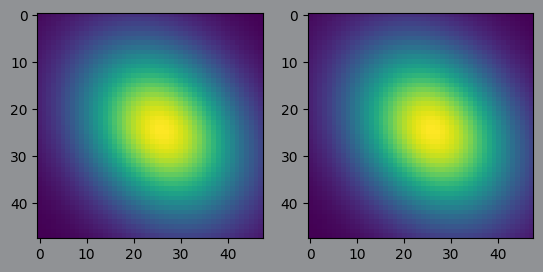

In [11]:
# Unquantized Gaussian Validation

predicted_gaussian_labels = np.array(model(generated_gaussians_images)) * std_params + avg_params
predicted_gaussians_images = generate_guassian(tf.convert_to_tensor(generated_gaussians_labels, dtype=tf.float32), (48,48))

rand_int = np.random.randint(low=0, high=num_generated_gaussians)
print(f'[Gaussian_Model MSE]: {mean_squared_error(generated_gaussians_labels, predicted_gaussian_labels)}')
print(f'[Gaussian_Model MAE]: {mean_absolute_error(generated_gaussians_labels, predicted_gaussian_labels)}')
print(f'[True Label #{rand_int}]:      {generated_gaussians_labels[rand_int]}')
print(f'[Predicted Label #{rand_int}]: {predicted_gaussian_labels[rand_int]}')

plt.subplot(1, 2, 1)
plt.imshow(generated_gaussians_images[rand_int])
plt.subplot(1, 2, 2)
plt.imshow(predicted_gaussians_images[rand_int])
plt.show()

In [21]:
# PTQ & Validation
total_bits_upper = 16

loss_arr = []
for total_bits in range(1, total_bits_upper + 1):
    for integer in range(total_bits + 1):
        loss_arr.append(quantize_and_validate(total_bits, integer, model, save_qmodel=NO)
)
        
loss_arr = np.array(loss_arr)

In [22]:
print("Total Bits | Integer | MSE | MAE")
print(loss_arr[loss_arr[:, 2].argsort()][:10])

Total Bits | Integer | MSE | MAE
[[15.         15.          3.65400985  1.25014093]
 [ 4.          4.          3.65693537  1.21861465]
 [12.         12.          3.66188216  1.25021876]
 [10.         10.          3.66427367  1.24786759]
 [16.         16.          3.67278556  1.22758354]
 [ 8.          8.          3.67702685  1.24579264]
 [11.         11.          3.68139458  1.25420196]
 [ 9.          9.          3.68974563  1.25111578]
 [13.         13.          3.70630232  1.25001896]
 [ 7.          7.          3.73410222  1.25535792]]


In [23]:
print("Total Bits | Integer | MSE | MAE")
print(loss_arr[loss_arr[:, 3].argsort()][:10])

Total Bits | Integer | MSE | MAE
[[ 4.          4.          3.65693537  1.21861465]
 [16.         16.          3.67278556  1.22758354]
 [ 8.          8.          3.67702685  1.24579264]
 [10.         10.          3.66427367  1.24786759]
 [13.         13.          3.70630232  1.25001896]
 [15.         15.          3.65400985  1.25014093]
 [12.         12.          3.66188216  1.25021876]
 [ 9.          9.          3.68974563  1.25111578]
 [ 5.          5.          3.85011328  1.25187292]
 [11.         11.          3.68139458  1.25420196]]


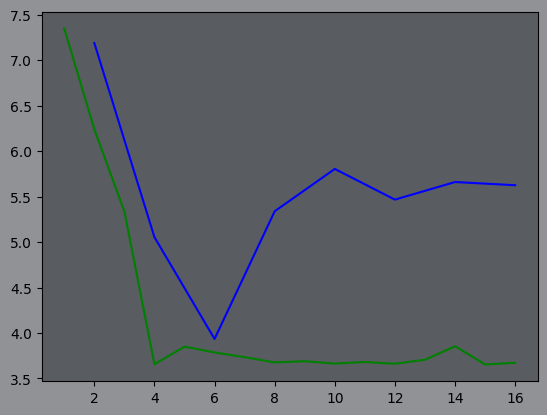

In [24]:
plot_elements = loss_arr[loss_arr[:, 0] == loss_arr[:, 1]]
plt.plot(plot_elements[:, 0], plot_elements[:, 2], color='green')
plot_elements = loss_arr[loss_arr[:, 0] == 2 * loss_arr[:, 1]]
plt.plot(plot_elements[:, 0], plot_elements[:, 2], color='blue')
plt.show()

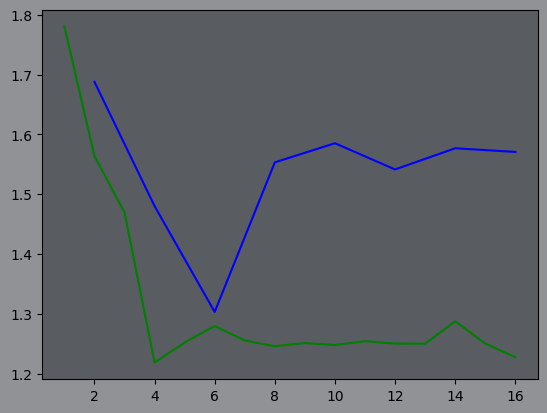

In [25]:
plot_elements = loss_arr[loss_arr[:, 0] == loss_arr[:, 1]]
plt.plot(plot_elements[:, 0], plot_elements[:, 3], color='green')
plot_elements = loss_arr[loss_arr[:, 0] == 2 * loss_arr[:, 1]]
plt.plot(plot_elements[:, 0], plot_elements[:, 3], color='blue')
plt.show()

In [ ]:
# Quantized Gaussian Validation

predicted_gaussian_labels = np.array(model(generated_gaussians_images)) * std_params + avg_params
predicted_gaussians_images = generate_guassian(tf.convert_to_tensor(generated_gaussians_labels, dtype=tf.float32), (48,48))

rand_int = np.random.randint(low=0, high=num_generated_gaussians)
print(f'[Gaussian_Model MSE]: {mean_squared_error(generated_gaussians_labels, predicted_gaussian_labels)}')
print(f'[Gaussian_Model MAE]: {mean_absolute_error(generated_gaussians_labels, predicted_gaussian_labels)}')
print(f'[True Label #{rand_int}]:      {generated_gaussians_labels[rand_int]}')
print(f'[Predicted Label #{rand_int}]: {predicted_gaussian_labels[rand_int]}')

plt.subplot(1, 2, 1)
plt.imshow(generated_gaussians_images[rand_int])
plt.subplot(1, 2, 2)
plt.imshow(predicted_gaussians_images[rand_int])
plt.show()
